## 【成功，央行公开市场操作（逆回购）】——优化了周末到期量自动顺延至下周一&画图不显示周末的功能

In [6]:
from WindPy import w
import pandas as pd
import numpy as np
import datetime 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
pd.set_option('colheader_justify','center')
pd.set_option('display.unicode.ambiguous_as_wide', True)
pd.set_option('display.unicode.east_asian_width', True)
pd.set_option('display.width', 1000) # 设置打印宽度(**重要**)
#以下为解决中文无法显示的问题
#针对matplotlib
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']

In [7]:
w.start()

.ErrorCode=0
.Data=[Already connected!]

In [8]:
#往前多少day
beginTime = "-30D"

#获取data
OMO_list = ["M0041372","M0041374","M0041378","M0329655"] #"M0062600":'逆回购到期量（周）'  'M5543273':'常备借贷便利（SLF）'（月）

OMO_data =(w.wsd(codes=OMO_list, fields="close", beginTime=beginTime, endTime=datetime.date.today(),
                 Days='Alldays',Period='D',Fill='Blank',usedf=True)
          )
'''
【参数示例】
Days——所有工作日:Weekdays/所有日历日:Alldays/排除所有非交易日:Trading| 范例：’Days=Trading’，默认Days=Trading
Period ——每天:D/每周:W/每月:M/每季度:Q/每半年:S/每年:Y *| 范例：’Period=D’ ，默认Period=D
Fill——沿用之前数据:Previous/返回空值:Blank| 范例：’Fill=Previous’，默认Fill=Blank|
usedf=True——使用dataframe格式
'''
OMO_data = OMO_data[1] #一个只有2个元素的tuple，第一个元素是一个"0"，取第二个元素，是一整个dataframe

#修改列名”
OMO_data.rename(columns={'M0041372':'逆回购7D', 
                         'M0041374':'逆回购14D',
                         'M0041378':'逆回购28D',
                         'M0329655':'逆回购63D',
                           },inplace=True)  #修改列名”

#添加列：逆回购当日到期量（7D）
OMO_data.insert(4, '逆回购7D到期量', OMO_data['逆回购7D'].shift(7))

#添加列：逆回购当日到期量（14D）
OMO_data.insert(5, '逆回购14D到期量', OMO_data['逆回购14D'].shift(14))

#列：【加总】当日逆回购总到期量
OMO_data['当日到期'] = OMO_data['逆回购7D到期量'].fillna(0) + OMO_data['逆回购14D到期量'].fillna(0) #这里必须加上fillna(0)，不然没法加总

# 计算净投放量——【注意】：不该在这里计算，应该在下面计算，因为下面会考虑补班时7D逆回购周末到期的情况
# OMO_data['净投放'] = OMO_data['逆回购7D'].fillna(0) + OMO_data['逆回购14D'].fillna(0) - OMO_data['当日到期']

#添加“是否为周末”列
OMO_data['是否为周末'] = pd.DatetimeIndex(OMO_data.index).dayofweek.isin([5,6]) #chatgpt

#【注】：考虑到万恶的补班，央行在周末日也会进行操作，导致到期也为周末日，所以添加此标签，记得将周末到期的统一加总归集至下一个周一
OMO_data['注意调整周末值'] = np.where(OMO_data['是否为周末']==True,"记得调整","-") 

# 重新排序
OMO_data_reindex_list = ['逆回购7D','逆回购14D','当日到期','注意调整周末值','逆回购28D','逆回购63D','逆回购7D到期量',
                         '逆回购14D到期量','是否为周末']
OMO_data = OMO_data.reindex(columns = OMO_data_reindex_list)

OMO_data.tail(10).fillna('-') #这里本身还是【保留Nan值】
                              #目的是为了后面可以画图，如果处理了Nan值会报错：unsupported operand type(s) for +: 'float' and 'str'

OMO_data

,逆回购7D,逆回购14D,当日到期,注意调整周末值,逆回购28D,逆回购63D,逆回购7D到期量,逆回购14D到期量,是否为周末
2024-12-26,1063.0,NaN,0.0,-,NaN,NaN,NaN,NaN,False
2024-12-27,1078.0,NaN,0.0,-,NaN,NaN,NaN,NaN,False
2024-12-28,NaN,NaN,0.0,记得调整,NaN,NaN,NaN,NaN,True
2024-12-29,NaN,NaN,0.0,记得调整,NaN,NaN,NaN,NaN,True
2024-12-30,891.0,NaN,0.0,-,NaN,NaN,NaN,NaN,False
2024-12-31,1577.0,NaN,0.0,-,NaN,NaN,NaN,NaN,False
2025-01-01,NaN,NaN,0.0,-,NaN,NaN,NaN,NaN,False
2025-01-02,248.0,NaN,1063.0,-,NaN,NaN,1063.0,NaN,False
2025-01-03,193.0,NaN,1078.0,-,NaN,NaN,1078.0,NaN,False
2025-01-04,NaN,NaN,0.0,记得调整,NaN,NaN,NaN,NaN,True


## 【☆☆☆到期日为周末进行调整】因为有时候补班，央行会在周末逆回购7D，那么到期也是在周末，这种情况就要顺延至下周一

In [9]:
OMO_data_1 = OMO_data.tail(10)

#创建新的空列
OMO_data_1['到期（周末调整）'] = 0

#【来自chatgpt】
# 循环遍历每一行，如果该行（i）第列'注意调整周末值'的元素为'记得调整'，就把对应的值加到'当日到期（周末调整）'列的下一行（i+1）
for i in range(len(OMO_data_1) - 1): #range(0, 9)
    if OMO_data_1.iloc[i]['注意调整周末值'] == '记得调整':   #df[A][B]——取第A行第B列的元素
        #这里只能使用df.at方法才有效
        OMO_data_1.at[OMO_data_1.index[i+1],'到期（周末调整）'] = (OMO_data_1.iloc[i]['到期（周末调整）']
                                                                   + OMO_data_1.iloc[i]['当日到期'])  

OMO_data_1['当日到期'] = OMO_data_1['当日到期'] + OMO_data_1['到期（周末调整）']   


# ☆☆☆净投放在这里计算才对！！！
OMO_data_1['净投放'] = OMO_data_1['逆回购7D'].fillna(0) + OMO_data_1['逆回购14D'].fillna(0) - OMO_data_1['当日到期']
  
#重新排序列的顺序
OMO_data_reindex_list_1 = ['逆回购7D','逆回购14D','当日到期','净投放','到期（周末调整）','逆回购7D到期量','注意调整周末值',
                           '逆回购14D到期量','逆回购28D','逆回购63D','是否为周末']
                          
OMO_data_1 = OMO_data_1.reindex(columns = OMO_data_reindex_list_1)

OMO_data_1.fillna('-')  #这里依然还是【保留Nan值】，目的是为了后面可以画图       

,逆回购7D,逆回购14D,当日到期,净投放,到期（周末调整）,逆回购7D到期量,注意调整周末值,逆回购14D到期量,逆回购28D,逆回购63D,是否为周末
2025-01-16,3405.0,-,41.0,3364.0,0,41.0,-,-,-,-,False
2025-01-17,1050.0,-,45.0,1005.0,0,45.0,-,-,-,-,False
2025-01-18,-,-,0.0,0.0,0,-,记得调整,-,-,-,True
2025-01-19,-,-,0.0,0.0,0,-,记得调整,-,-,-,True
2025-01-20,1230.0,-,248.0,982.0,0,248.0,-,-,-,-,False
2025-01-21,-,2560.0,550.0,2010.0,0,550.0,-,-,-,-,False
2025-01-22,-,11575.0,9595.0,1980.0,0,9595.0,-,-,-,-,False
2025-01-23,-,4800.0,3405.0,1395.0,0,3405.0,-,-,-,-,False
2025-01-24,-,2840.0,1050.0,1790.0,0,1050.0,-,-,-,-,False
2025-01-25,-,-,0.0,0.0,0,-,记得调整,-,-,-,True


## 选取近7天

In [10]:
OMO_data_currentweek = OMO_data_1[['逆回购7D','逆回购14D','当日到期','净投放','注意调整周末值']]
OMO_data_currentweek = OMO_data_currentweek.tail(7).T

#以上用于画图，新建一个对象用于展示
OMO_data_currentweek_show = OMO_data_currentweek.copy()
OMO_data_currentweek_show['本周合计'] = OMO_data_currentweek_show.iloc[0:4,:].sum(axis=1) # 按行求和，添加为新列
OMO_data_currentweek_show.fillna('-') #这里依然还是【保留Nan值】，目的是为了后面可以画图  

,2025-01-19,2025-01-20,2025-01-21,2025-01-22,2025-01-23,2025-01-24,2025-01-25,本周合计
逆回购7D,-,1230.0,-,-,-,-,-,1230.0
逆回购14D,-,-,2560.0,11575.0,4800.0,2840.0,-,21775.0
当日到期,0.0,248.0,550.0,9595.0,3405.0,1050.0,0.0,14848.0
净投放,0.0,982.0,2010.0,1980.0,1395.0,1790.0,0.0,8157.0
注意调整周末值,记得调整,-,-,-,-,-,记得调整,-


## 剔除为周末的列——为了待会儿画图不显示日期为周末的bar

In [11]:
# 先剔除最后一行“注意调整周末值”
OMO_data_currentweek = OMO_data_currentweek.iloc[0:len(OMO_data_currentweek)-1,]
# 来自【chatgpt】
OMO_data_currentweek.columns = pd.to_datetime(OMO_data_currentweek.columns)
OMO_data_currentweek = OMO_data_currentweek.loc[:, ~(OMO_data_currentweek.columns.dayofweek.isin([5, 6]))]
OMO_data_currentweek

,2025-01-20,2025-01-21,2025-01-22,2025-01-23,2025-01-24
逆回购7D,1230.0,NaN,NaN,NaN,NaN
逆回购14D,NaN,2560.0,11575.0,4800.0,2840.0
当日到期,248.0,550.0,9595.0,3405.0,1050.0
净投放,982.0,2010.0,1980.0,1395.0,1790.0


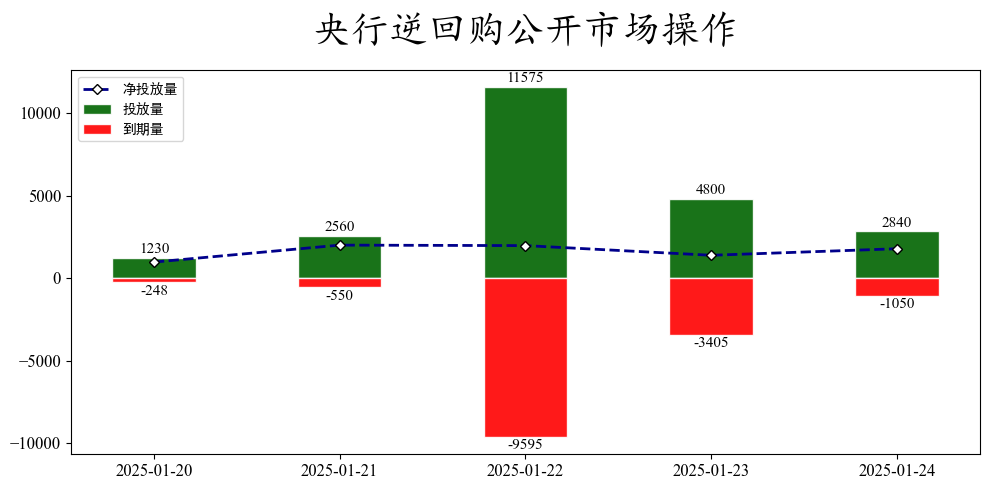

In [12]:
plt.figure(figsize=(10,5))  # dpi=100
# plt.style.use('tableau-colorblind10')  #效果不错的有：seaborn-white、seaborn-whitegrid、seaborn-ticks

#创建x、y列表，作为plt.bar的input——注意y是不一样的，要做区分
x_input = []
y_input_1 = []
y_input_2 = []
y_input_diff = [] # 新建列表存储y的数值为2个bar之间的差
for i in range(OMO_data_currentweek.shape[1]):   #range(0, 7)
    x_input.append(OMO_data_currentweek.columns.values[i])  
    y_input_1.append(OMO_data_currentweek.fillna(0).iat[0,i] + OMO_data_currentweek.fillna(0).iat[1,i])  #7D和14D【之合】
    y_input_2.append(-OMO_data_currentweek.fillna(0).iat[2,i])  #这里用“-”让图像往y轴下方显示
    y_input_diff.append(y_input_1[i] + y_input_2[i]) # 计算差值——【注】：因为y_input_2本身就为“负值”，所以这里为“+”
    
#【☆☆☆重要】：由于上一步骤“剔除为周末额列”，将x_input列表中所有元素改为了np.datetime64('2023-02-06T00:00:00.000000000')格式
# 会影响画图，显示非常丑，所以要做此步更改，将格式改为“2023-02-06”的样式
# Chatgpt
x_input = [np.datetime_as_string(d, unit='D') for d in x_input]        
                  
# 参数说明：  
# plt.bar(x, y, width，color, edgecolor, bottom, linewidth, align, tick_label, align)
# x：指定x轴上数值
# y：指定y轴上的数值
# width：表示柱状图的宽度，取值在0~1之间，默认为0.8
# color：柱状图的填充色——好看的颜色：steelblue midnightblue firebrick brown orangered seagreen mediumseagreen #d0fefe #010fcc
# 好看的颜色：#8ab8fe #c20078 #b04e0f #0066fe darkblue deepskyblue
# edgecolor：柱状图的边框颜色
# bottom：柱状图底部离横轴的距离，也就是y轴的起始坐标
# linewidth：柱状图边框宽度
# align：指定x轴上对齐方式，"center","lege"边缘 
# tick_label：柱状图的刻度标签，也可直接将标签赋值给x    
# log：柱状图y周使用科学计算方法，bool类型；
# orientation：柱状图是竖直还是水平，竖直：“vertical”，水平条：“horizontal”

#画当日新增量    
bar1 = plt.bar(x_input, y_input_1, width=0.45, color='darkgreen', edgecolor="white", label="投放量",align="center", linewidth =1,
        alpha=0.9)    

#画当日到期量    
bar2 = plt.bar(x_input, y_input_2, width=0.45, color='red', edgecolor="white", label="到期量",align="center", linewidth =1,
        alpha=0.9) 

# 添加折线图
plt.plot(x_input, y_input_diff, color='darkblue', linewidth=2, linestyle='dashed',marker='D', markersize=5, 
         markeredgecolor='black', markerfacecolor='white',label='净投放量') 

# 设置标题、标签、图例    
plt.title('央行逆回购公开市场操作',family='Kaiti', fontsize=28, fontweight=5, loc='center', pad=20)

# plt.xlabel('日期',family='Kaiti', fontsize = 15, labelpad=5)
# plt.ylabel('值',family='Kaiti', fontsize = 15, labelpad=5,rotation =90)

#打开图例
plt.legend(loc='upper left')  #,labels=['投放量','到期量']

#设置x轴刻度
plt.xticks(fontproperties= 'Times New Roman', fontsize=12)

#设置y轴刻度
plt.ylim(OMO_data_currentweek.fillna(0).iloc[:4,].values.min()*1.02,OMO_data_currentweek.fillna(0).iloc[:4,].values.max()*1.02) 
                                 #取前4行，排除最后一行，因为str类型无法取min或max        #乘以1.02是为了稍微放大区间，为了好看
plt.yticks(fontproperties= 'Times New Roman', fontsize=12) 
    
#添加每个bar的数据标签
plt.bar_label(bar1,fontproperties= 'Times New Roman',fontsize=11,fontweight=5,padding=1.2)#padding：数据与条形图中的每个条形的水平距离 
plt.bar_label(bar2,fontproperties= 'Times New Roman',fontsize=11,fontweight=5,padding=1.2)     

# #添加【折线图】每个marker的数据标签——chatgpt——但显示了不好看，算了
# for i, j in zip(x_input, y_input_diff):
#     idx = x_input.index(i)
#     plt.text(i, j, str(round(j, 2)), ha='center', va='bottom',
#              fontsize=10, fontweight=15, color='darkblue')
#     plt.plot(i, j, color='deepskyblue', marker='D', markersize=7,
#              markeredgecolor='black', markerfacecolor='white')

#调整尺寸
plt.autoscale(enable=True, axis='both', tight=None)

plt.tight_layout()
# 显示图形
plt.show()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~以下为使用for循环的思路，但是这样图例上会有显示问题，故此放弃~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# plt.figure(figsize=(15,6), dpi=80)
# #画当日新增量——这里是if&else判断是为了至显示1个label，不然就会有一排label，太难看了
# for i in range(OMO_data_currentweek.shape[1]):   #range(0, 7)
#     if i <= OMO_data_currentweek.shape[1]-1:
#         plt.bar(OMO_data_currentweek.columns.values[i], OMO_data_currentweek.iat[0,i], label=None,
#            width=0.4, color='steelblue', edgecolor="black", alpha=0.7
#                )
#     else:
#         plt.bar(OMO_data_currentweek.columns.values[i], OMO_data_currentweek.iat[0,i], label="投放量",
#            width=0.4, color='steelblue', edgecolor="black", alpha=0.7
#                )

# #画当日到期量   
# for i in range(OMO_data_currentweek.shape[1]):
#     if i <= OMO_data_currentweek.shape[1]-1:
#         plt.bar(OMO_data_currentweek.columns.values[i], -OMO_data_currentweek.iat[2,i], #label=OMO_data_currentweek.columns.values[i],
#                width=0.4, color='firebrick', edgecolor="black", alpha=0.7)
#     else:
#         plt.bar(OMO_data_currentweek.columns.values[i], -OMO_data_currentweek.iat[0,i], label="到期量",
#            width=0.4, color='steelblue', edgecolor="black", alpha=0.7)


# 【代码——剔除注释后的精简版】
# plt.figure(figsize=(9,5))  # dpi=100

# x_input = []
# y_input_1 = []
# y_input_2 = []
# for i in range(OMO_data_currentweek.shape[1]):   
#     x_input.append(OMO_data_currentweek.columns.values[i])  
#     y_input_1.append(OMO_data_currentweek.fillna(0).iat[0,i] + OMO_data_currentweek.fillna(0).iat[1,i])  #7D和14D【之合】
#     y_input_2.append(-OMO_data_currentweek.fillna(0).iat[2,i])  

# x_input = [np.datetime_as_string(d, unit='D') for d in x_input]        
        
# bar1 = plt.bar(x_input, y_input_1, width=0.45, color='darkblue', edgecolor="white", label="投放量",align="center", linewidth =1,
#         alpha=0.85)    

  
# bar2 = plt.bar(x_input, y_input_2, width=0.45, color='orangered', edgecolor="white", label="到期量",align="center", linewidth =1,
#         alpha=0.9) 

# plt.plot(x_input, y_input_diff, color='deepskyblue', linewidth=2, linestyle='dashed',marker='D', markersize=7, 
#          markeredgecolor='black', markerfacecolor='white',label='净投放量') 

# plt.title('央行逆回购公开市场操作',family='Kaiti', fontsize=38, fontweight=5, loc='center', pad=15)

# plt.legend(loc='upper left') 

# plt.xticks(fontproperties= 'Times New Roman', fontsize=12)

# plt.ylim(OMO_data_currentweek.fillna(0).iloc[:4,].values.min()*1.02,OMO_data_currentweek.fillna(0).iloc[:4,].values.max()*1.02) 
                                 
# plt.yticks(fontproperties= 'Times New Roman', fontsize=12) 
    
# plt.bar_label(bar1,fontproperties= 'Times New Roman',fontsize=10,fontweight=5,padding=1.2)#padding：数据与条形图中的每个条形的水平距离 
# plt.bar_label(bar2,fontproperties= 'Times New Roman',fontsize=10,fontweight=5,padding=1.2)     

# plt.autoscale(enable=True, axis='both', tight=None)

# plt.tight_layout()
# plt.show()

## 下面为chatgpt调色之后的版本

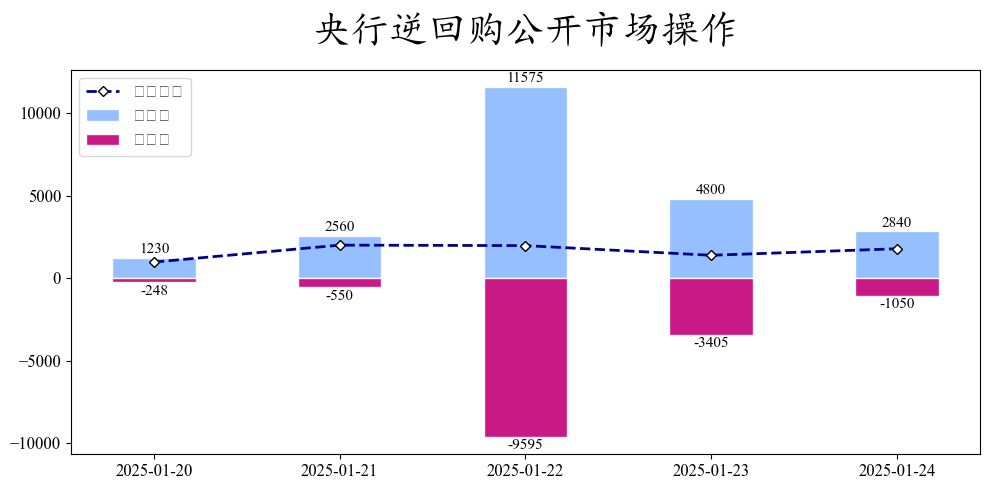

In [13]:
plt.figure(figsize=(10,5))  # dpi=100

#创建x、y列表，作为plt.bar的input——注意y是不一样的，要做区分
x_input = []
y_input_1 = []
y_input_2 = []
y_input_diff = []
for i in range(OMO_data_currentweek.shape[1]):
    x_input.append(OMO_data_currentweek.columns.values[i])
    y_input_1.append(OMO_data_currentweek.fillna(0).iat[0,i] + OMO_data_currentweek.fillna(0).iat[1,i])
    y_input_2.append(-OMO_data_currentweek.fillna(0).iat[2,i])
    y_input_diff.append(y_input_1[i] + y_input_2[i])
    
# Chatgpt
x_input = [np.datetime_as_string(d, unit='D') for d in x_input]        
                  
#画当日新增量    
bar1 = plt.bar(x_input, y_input_1, width=0.45, color='#8ab8fe', edgecolor="white", label="投放量", align="center", linewidth=1, alpha=0.9)    

#画当日到期量    
bar2 = plt.bar(x_input, y_input_2, width=0.45, color='#c20078', edgecolor="white", label="到期量", align="center", linewidth=1, alpha=0.9) 

# 添加折线图
plt.plot(x_input, y_input_diff, color='darkblue', linewidth=2, linestyle='dashed', marker='D', markersize=5, 
         markeredgecolor='black', markerfacecolor='white', label='净投放量') 

# 设置标题、标签、图例    
plt.title('央行逆回购公开市场操作', family='Kaiti', fontsize=28, fontweight=5, loc='center', pad=20)

#打开图例
plt.legend(loc='upper left', prop={'size': 12, 'family': 'Times New Roman'})  

#设置x轴刻度
plt.xticks(fontproperties='Times New Roman', fontsize=12)

#设置y轴刻度
plt.ylim(OMO_data_currentweek.fillna(0).iloc[:4,].values.min()*1.02, OMO_data_currentweek.fillna(0).iloc[:4,].values.max()*1.02) 
                                 
plt.yticks(fontproperties='Times New Roman', fontsize=12) 
    
#添加每个bar的数据标签
plt.bar_label(bar1, fontproperties='Times New Roman', fontsize=11, fontweight=5, padding=1.2)
plt.bar_label(bar2, fontproperties='Times New Roman', fontsize=11, fontweight=5, padding=1.2)     

#调整尺寸
plt.autoscale(enable=True, axis='both', tight=None)

plt.tight_layout()
# 显示图形
plt.show()


## dataframe展示

In [14]:
OMO_data_currentweek_show = OMO_data_currentweek.fillna("-")

OMO_data_currentweek_show

,2025-01-20,2025-01-21,2025-01-22,2025-01-23,2025-01-24
逆回购7D,1230.0,-,-,-,-
逆回购14D,-,2560.0,11575.0,4800.0,2840.0
当日到期,248.0,550.0,9595.0,3405.0,1050.0
净投放,982.0,2010.0,1980.0,1395.0,1790.0
